Goal : Test the implementation of the isometries to unitaries functionality in `mps_circuit_helpers.py`

In [2]:
cd ..

/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS


Import necessary libraries and modules


In [33]:
from pennylane import numpy as np
from MPScumulant import MPS_c
from tqdm import tqdm 

import matplotlib.pyplot as plt
import pennylane as qml
import metrics
import mps_circuit_helpers
import mps_circuit


In [34]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check the properties of the original trained MPS

In [35]:
m = MPS_c(16)
m.loadMPS('BS-MPS')

for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 8)
3 (8, 2, 15)
4 (15, 2, 16)
5 (16, 2, 16)
6 (16, 2, 16)
7 (16, 2, 15)
8 (15, 2, 16)
9 (16, 2, 16)
10 (16, 2, 16)
11 (16, 2, 15)
12 (15, 2, 8)
13 (8, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


Check if the core tensors in the MPS are right or left isometries after merging the open axis with either the left (0) or right (2) virtual axis

In [36]:
mps_circuit_helpers.are_isometries(m)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 8) True True
3 (8, 2, 15) True False
4 (15, 2, 16) True False
5 (16, 2, 16) True False
6 (16, 2, 16) True False
7 (16, 2, 15) True False
8 (15, 2, 16) True False
9 (16, 2, 16) True False
10 (16, 2, 16) True False
11 (16, 2, 15) True False
12 (15, 2, 8) True False
13 (8, 2, 4) True False
14 (4, 2, 2) False False
15 (2, 2, 1) False False


Get a list of multi-qubit unitaries from an MPS corresponding to unitaries which can be used to build the staircase circuit in qml


In [38]:
mps_unitaries = mps_circuit_helpers.get_mps_unitaries(m)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 16), 8
i = 4, (16, 2, 16), 16
i = 5, (16, 2, 16), 16
i = 6, (16, 2, 16), 16
i = 7, (16, 2, 16), 16
i = 8, (16, 2, 16), 16
i = 9, (16, 2, 16), 16
i = 10, (16, 2, 16), 16
i = 11, (16, 2, 16), 16
i = 12, (16, 2, 8), 16
i = 13, (8, 2, 4), 8
i = 14, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


Check whether matrices in mps_unitaries are unitary matrices

In [39]:
for unitary in mps_unitaries:
    print(mps_circuit_helpers.is_unitary(unitary))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Load bars and stripes dataset

In [40]:
data = np.load('BStest/BSdata.npy')

Create circuit from mps_unitaries and train it

In [ ]:
n_qubits = 5
n_wires = 16
wire = 1
u_wires = [wire] + list(range(wire+1, wire+n_qubits))
n_wires = len(mps_unitaries) + 1
weights = np.random.normal(size=(45, 1), requires_grad=True)


dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def circuit(weights):

    for wire in range(n_wires-1):
        unitary = mps_unitaries[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire+1, wire+n_qubits))
        qml.QubitUnitary(unitary, wires=u_wires)

    i = 0
    while i <= n_wires-3:
        qml.RX(*weights[i], wires=i)
        qml.RX(*weights[i+1], wires=i+1)
        qml.RX(*weights[i+1], wires=i+2)
        qml.CNOT(wires=[i,i+1])
        qml.CNOT(wires=[i,i+2])
        qml.CNOT(wires=[i+1,i+2])
        i += 1

    return qml.probs(wires=range(n_wires))

def loss(weights):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])      
    probs = circuit(weights)
    return metrics.kl_divergence(probs)

opt = qml.GradientDescentOptimizer(stepsize=0.2)

n_its = 2

loss_track = []

for it in tqdm(range(n_its)):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 50 == 0:
        print(_loss)
    loss_track.append(_loss)

How the circuit looks like?

(<Figure size 6100x1700 with 1 Axes>, <Axes: >)

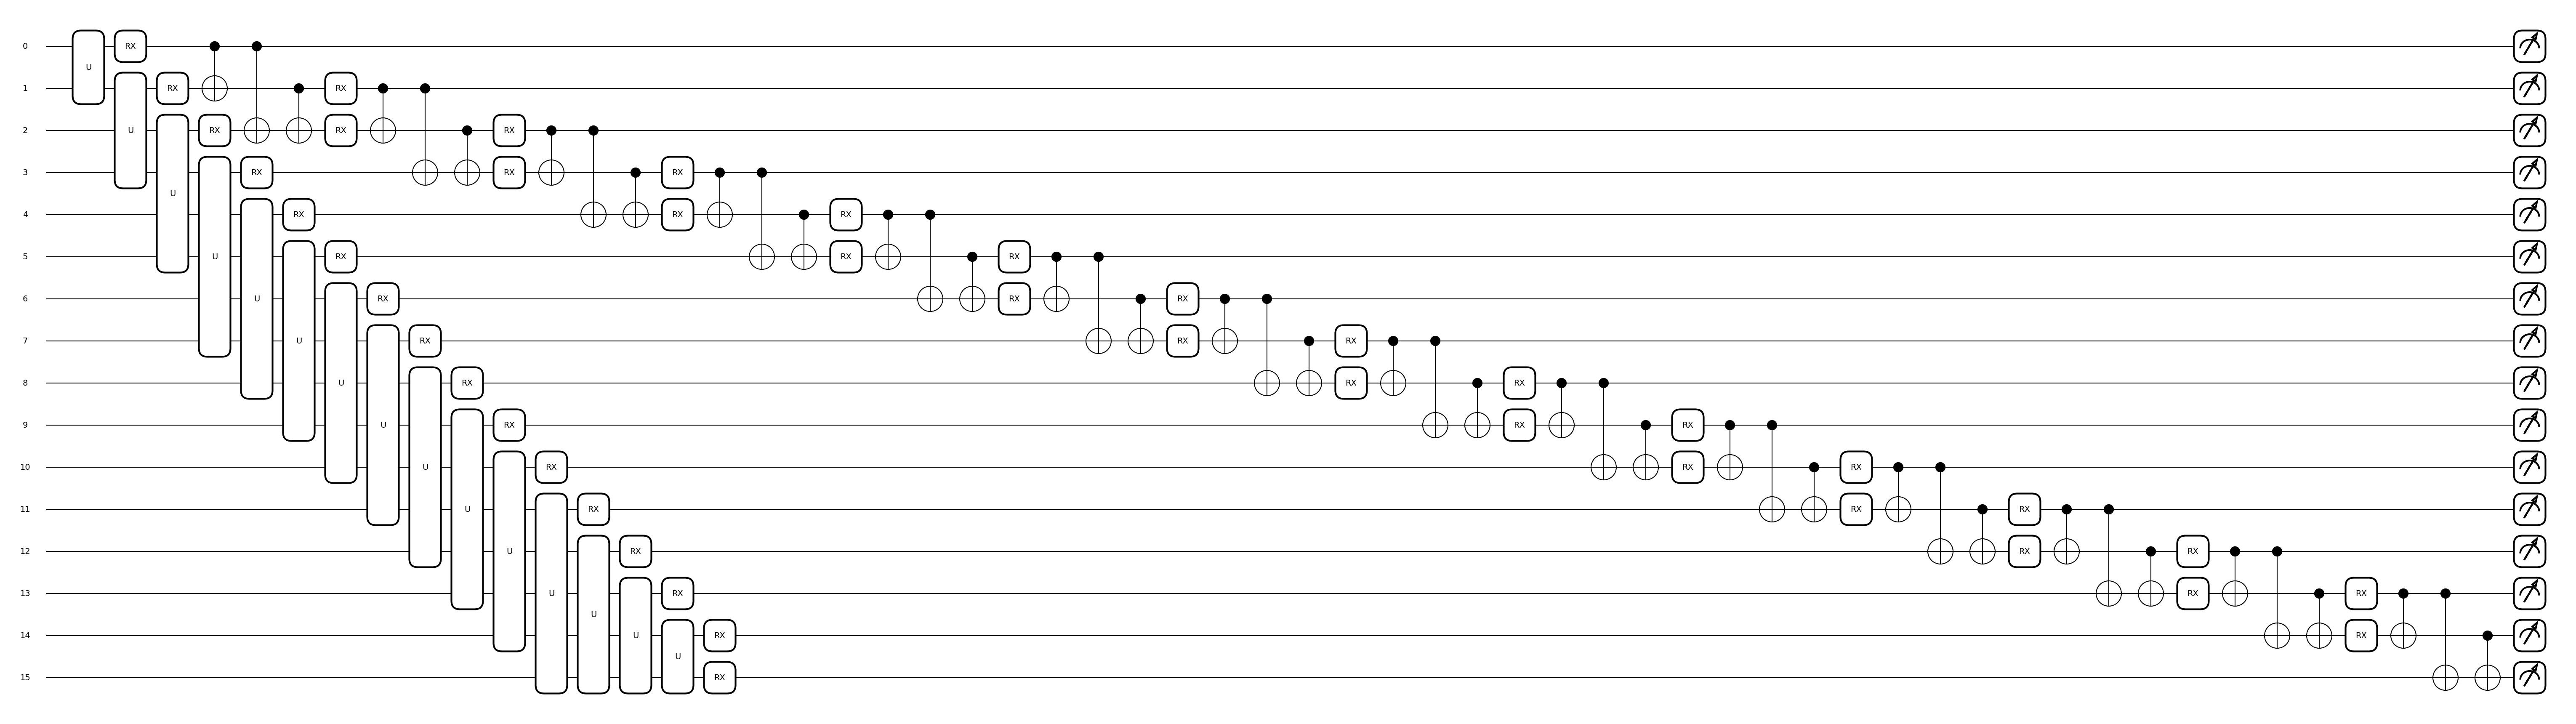

In [43]:
qml.drawer.draw_mpl(circuit)(weights) 

Plot the KL-Divergence vs iterations

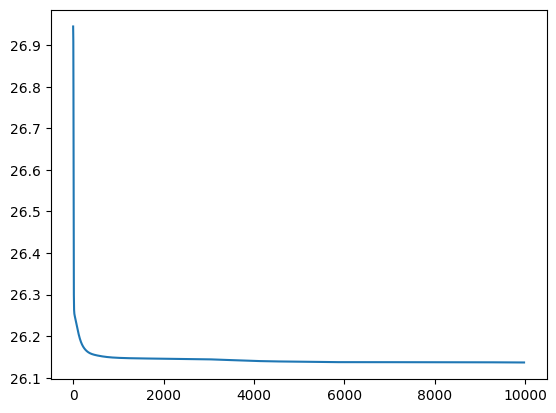

In [80]:
plt.plot(loss_track)